This notebook tries to search for optimal fixed policies (e.g. constant mortality) that maximize the objective (i.e. expected net reward). Here I try [scikit-optimize](https://scikit-optimize.github.io/stable/index.html) routines which are designed for noisy functions and compare to a brute-force parallel grid search.  

In [1]:
# %pip install -e ..
# %pip install scikit-optimize

In [1]:
from rl4caribou import Caribou
from skopt import gp_minimize, gbrt_minimize
import polars as pl
import numpy as np
from plotnine import ggplot, aes, geom_point, geom_ribbon

import pandas as pd
from skopt.plots import plot_objective, plot_convergence


Here is an example of a simple fixed action policy.  It will apply a fixed hunting effort (potentially zero) each year to Moose, and another fixed effort to Wolves.  

In [2]:
class fixed_effort:
    def __init__(self, effort):
        self.effort = np.array(effort, dtype=np.float32)

    def predict(self, observation, **kwargs):
        action = self.effort * 2 - 1
        return action, {}

pacifist = fixed_effort([0., 0.])

In [3]:
am = {"current": 1, "full_rest": 0.5}
ab = {"current": 5, "full_rest": 1}

parameters = {
    "r_m": np.float32(0.5),
    "r_b": np.float32(0.45),
    #
    "alpha_mm": np.float32(0.1),
    "alpha_bb": np.float32(0.1),
    "alpha_bm": np.float32(0.05),
    "alpha_mb": np.float32(0.05),
    #
    "a_M": am["current"],
    "a_B": ab["current"],
    # "a_M": 1,
    # "a_B": 2,
    #
    "K_m": np.float32(1.1),
    "K_b": np.float32(0.40),
    #
    "h_B": np.float32(0.031),
    "h_M": np.float32(0.31),
    #
    "x": np.float32(2),
    "u": np.float32(1),
    "d": np.float32(0.3),
    #
    "sigma_M": np.float32(0.2),
    "sigma_B": np.float32(0.25),
    "sigma_W": np.float32(0.2),
    # "sigma_M": np.float32(0.),
    # "sigma_B": np.float32(0.),
    # "sigma_W": np.float32(0.),
    "additive_sigma": np.float32(0.005),
}


config = {
    'parameters': parameters,
    'initial_pop': np.float32([0.572079, 0.025453, 0.911731]),
    # ^ use convergence point for null action and no stochasticity
}

env = Caribou(config=config)
obs = env.reset()
action, _ = pacifist.predict(obs)
env.step(action)

(array([-0.88323575, -0.9932028 , -0.81746125], dtype=float32),
 -6.324660778045655e-05,
 False,
 False,
 {})

## Fixed policy evaluation helpers

This function simulates the dynamics under any given manager.  Each timestep, the manager gets an observation of the population (Caribou, Moose, Wolves), and decides ("predicts") what harvest action to take on wolves and moose to maximize the overall net utility over the full simulation.

A helper utility runs this simulation 10 times and returns the mean and summary statistics.  

In [4]:
import ray

@ray.remote
def gen_ep_rew(manager, env):
    episode_reward = 0.0
    observation, _ = env.reset()
    for t in range(env.Tmax):
        action, _ = manager.predict(observation)
        observation, reward, terminated, done, info = env.step(action)
        episode_reward += reward
        if terminated or done:
            break
    return episode_reward

def gather_stats(manager, env, N=200):
    results = ray.get(
        [gen_ep_rew.remote(manager, env) for _ in range(N)]
    )
    ray.shutdown()
    #
    y = np.mean(results)
    sigma = np.std(results)
    ymin = y - sigma
    ymax = y + sigma
    return y, ymin, ymax 

In [9]:
gather_stats(pacifist, env)

2024-05-16 22:25:38,232	INFO worker.py:1749 -- Started a local Ray instance.


(-5.567889918454439, -6.924977668806896, -4.210802168101981)

## Determine optimal mortality policy

Use Bayesian optimization techniques for nonlinear and stochastic functions from Scikit-Optimize (e.g. Gaussian Process estimation) to estimate the optimal fixed mortality policy for both wolves and moose: (err, maybe this can be done analytically too).  Note we define the function to be minimized, `g(x)` as a function of the actions, `x`. Note we report the _negative_ mean reward since the optimizer tries to _minimize_ the value.  

In [5]:
def g(x):
    manager = fixed_effort(x)
    out = gather_stats(manager, env)
    return - out[0]

In [12]:
%%time
res = gp_minimize(g, [(0.0, 1.0), (0.0, 1.0)], n_calls = 50, verbose=True)
res.fun, res.x

Iteration No: 1 started. Evaluating function at random point.


2024-05-16 22:26:41,368	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 1 ended. Evaluation done at random point.
Time taken: 6.9099
Function value obtained: 8.3944
Current minimum: 8.3944
Iteration No: 2 started. Evaluating function at random point.


2024-05-16 22:26:48,140	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 2 ended. Evaluation done at random point.
Time taken: 6.6931
Function value obtained: 8.5189
Current minimum: 8.3944
Iteration No: 3 started. Evaluating function at random point.


2024-05-16 22:26:54,954	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 3 ended. Evaluation done at random point.
Time taken: 6.8978
Function value obtained: 7.8332
Current minimum: 7.8332
Iteration No: 4 started. Evaluating function at random point.


2024-05-16 22:27:01,789	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 4 ended. Evaluation done at random point.
Time taken: 6.5554
Function value obtained: 6.4482
Current minimum: 6.4482
Iteration No: 5 started. Evaluating function at random point.


2024-05-16 22:27:08,324	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 5 ended. Evaluation done at random point.
Time taken: 6.7635
Function value obtained: 7.8851
Current minimum: 6.4482
Iteration No: 6 started. Evaluating function at random point.


2024-05-16 22:27:15,202	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 6 ended. Evaluation done at random point.
Time taken: 6.6887
Function value obtained: 7.4570
Current minimum: 6.4482
Iteration No: 7 started. Evaluating function at random point.


2024-05-16 22:27:21,924	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 7 ended. Evaluation done at random point.
Time taken: 6.7629
Function value obtained: 7.4776
Current minimum: 6.4482
Iteration No: 8 started. Evaluating function at random point.


2024-05-16 22:27:28,673	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 8 ended. Evaluation done at random point.
Time taken: 6.6721
Function value obtained: 8.2757
Current minimum: 6.4482
Iteration No: 9 started. Evaluating function at random point.


2024-05-16 22:27:35,228	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 9 ended. Evaluation done at random point.
Time taken: 6.4267
Function value obtained: 3.4761
Current minimum: 3.4761
Iteration No: 10 started. Evaluating function at random point.


2024-05-16 22:27:41,699	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 10 ended. Evaluation done at random point.
Time taken: 6.8884
Function value obtained: 7.7584
Current minimum: 3.4761
Iteration No: 11 started. Searching for the next optimal point.


2024-05-16 22:27:48,590	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 6.9206
Function value obtained: 7.7113
Current minimum: 3.4761
Iteration No: 12 started. Searching for the next optimal point.


2024-05-16 22:27:55,490	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 7.0718
Function value obtained: 3.6899
Current minimum: 3.4761
Iteration No: 13 started. Searching for the next optimal point.


2024-05-16 22:28:02,737	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 7.3528
Function value obtained: 8.1123
Current minimum: 3.4761
Iteration No: 14 started. Searching for the next optimal point.


2024-05-16 22:28:10,032	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 7.2734
Function value obtained: 6.6178
Current minimum: 3.4761
Iteration No: 15 started. Searching for the next optimal point.


2024-05-16 22:28:17,313	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 6.9263
Function value obtained: 3.8129
Current minimum: 3.4761
Iteration No: 16 started. Searching for the next optimal point.


2024-05-16 22:28:24,228	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 7.4502
Function value obtained: 3.3117
Current minimum: 3.3117
Iteration No: 17 started. Searching for the next optimal point.


2024-05-16 22:28:31,652	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 7.2443
Function value obtained: 2.7624
Current minimum: 2.7624
Iteration No: 18 started. Searching for the next optimal point.


2024-05-16 22:28:38,831	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 7.2384
Function value obtained: 3.4623
Current minimum: 2.7624
Iteration No: 19 started. Searching for the next optimal point.


2024-05-16 22:28:46,141	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 7.2537
Function value obtained: 1.8911
Current minimum: 1.8911
Iteration No: 20 started. Searching for the next optimal point.


2024-05-16 22:28:53,438	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 7.3900
Function value obtained: 2.7528
Current minimum: 1.8911
Iteration No: 21 started. Searching for the next optimal point.


2024-05-16 22:29:00,823	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 7.0239
Function value obtained: 1.7782
Current minimum: 1.7782
Iteration No: 22 started. Searching for the next optimal point.


2024-05-16 22:29:07,728	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 7.8995
Function value obtained: 1.9291
Current minimum: 1.7782
Iteration No: 23 started. Searching for the next optimal point.


2024-05-16 22:29:15,649	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 7.1420
Function value obtained: 2.1447
Current minimum: 1.7782
Iteration No: 24 started. Searching for the next optimal point.


2024-05-16 22:29:22,806	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 7.2428
Function value obtained: 1.7375
Current minimum: 1.7375
Iteration No: 25 started. Searching for the next optimal point.


2024-05-16 22:29:30,149	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 7.1471
Function value obtained: 1.9571
Current minimum: 1.7375
Iteration No: 26 started. Searching for the next optimal point.


2024-05-16 22:29:37,189	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 7.9695
Function value obtained: 1.7196
Current minimum: 1.7196
Iteration No: 27 started. Searching for the next optimal point.


2024-05-16 22:29:45,309	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 7.4276
Function value obtained: 1.9116
Current minimum: 1.7196
Iteration No: 28 started. Searching for the next optimal point.


2024-05-16 22:29:52,623	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 7.0555
Function value obtained: 5.8750
Current minimum: 1.7196
Iteration No: 29 started. Searching for the next optimal point.


2024-05-16 22:29:59,767	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 7.3063
Function value obtained: 1.7385
Current minimum: 1.7196
Iteration No: 30 started. Searching for the next optimal point.


2024-05-16 22:30:06,984	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 7.0246
Function value obtained: 1.7629
Current minimum: 1.7196
Iteration No: 31 started. Searching for the next optimal point.


2024-05-16 22:30:14,010	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 8.0223
Function value obtained: 1.8089
Current minimum: 1.7196
Iteration No: 32 started. Searching for the next optimal point.


2024-05-16 22:30:22,140	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 7.3475
Function value obtained: 1.8630
Current minimum: 1.7196
Iteration No: 33 started. Searching for the next optimal point.


2024-05-16 22:30:29,471	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 7.1381
Function value obtained: 2.2714
Current minimum: 1.7196
Iteration No: 34 started. Searching for the next optimal point.


2024-05-16 22:30:36,617	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 7.0736
Function value obtained: 5.7942
Current minimum: 1.7196
Iteration No: 35 started. Searching for the next optimal point.


2024-05-16 22:30:43,643	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 7.1881
Function value obtained: 4.5248
Current minimum: 1.7196
Iteration No: 36 started. Searching for the next optimal point.


2024-05-16 22:30:50,814	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 7.3308
Function value obtained: 1.6878
Current minimum: 1.6878
Iteration No: 37 started. Searching for the next optimal point.


2024-05-16 22:30:58,177	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 7.1597
Function value obtained: 8.8895
Current minimum: 1.6878
Iteration No: 38 started. Searching for the next optimal point.


2024-05-16 22:31:05,404	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 38 ended. Search finished for the next optimal point.
Time taken: 8.1257
Function value obtained: 4.6135
Current minimum: 1.6878
Iteration No: 39 started. Searching for the next optimal point.


2024-05-16 22:31:13,449	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 7.2257
Function value obtained: 7.7961
Current minimum: 1.6878
Iteration No: 40 started. Searching for the next optimal point.


2024-05-16 22:31:20,679	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 8.0782
Function value obtained: 7.7090
Current minimum: 1.6878
Iteration No: 41 started. Searching for the next optimal point.


2024-05-16 22:31:28,752	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 7.3119
Function value obtained: 1.7442
Current minimum: 1.6878
Iteration No: 42 started. Searching for the next optimal point.


2024-05-16 22:31:36,168	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 7.3256
Function value obtained: 7.5428
Current minimum: 1.6878
Iteration No: 43 started. Searching for the next optimal point.


2024-05-16 22:31:44,425	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 8.2707
Function value obtained: 8.8123
Current minimum: 1.6878
Iteration No: 44 started. Searching for the next optimal point.


2024-05-16 22:31:51,663	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 8.0775
Function value obtained: 7.2416
Current minimum: 1.6878
Iteration No: 45 started. Searching for the next optimal point.


2024-05-16 22:31:59,751	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 7.9931
Function value obtained: 4.1048
Current minimum: 1.6878
Iteration No: 46 started. Searching for the next optimal point.


2024-05-16 22:32:07,760	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 46 ended. Search finished for the next optimal point.
Time taken: 7.3357
Function value obtained: 10.8838
Current minimum: 1.6878
Iteration No: 47 started. Searching for the next optimal point.


2024-05-16 22:32:15,206	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 47 ended. Search finished for the next optimal point.
Time taken: 7.4287
Function value obtained: 6.6997
Current minimum: 1.6878
Iteration No: 48 started. Searching for the next optimal point.


2024-05-16 22:32:22,631	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 48 ended. Search finished for the next optimal point.
Time taken: 8.4265
Function value obtained: 5.9701
Current minimum: 1.6878
Iteration No: 49 started. Searching for the next optimal point.


2024-05-16 22:32:31,077	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 49 ended. Search finished for the next optimal point.
Time taken: 8.1849
Function value obtained: 6.6603
Current minimum: 1.6878
Iteration No: 50 started. Searching for the next optimal point.


2024-05-16 22:32:39,149	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 50 ended. Search finished for the next optimal point.
Time taken: 8.1697
Function value obtained: 8.1234
Current minimum: 1.6878
CPU times: user 7min 21s, sys: 9min 19s, total: 16min 41s
Wall time: 6min 5s


(1.6878340780852437, [0.018989021076692904, 0.3169121824404405])

<Axes: >

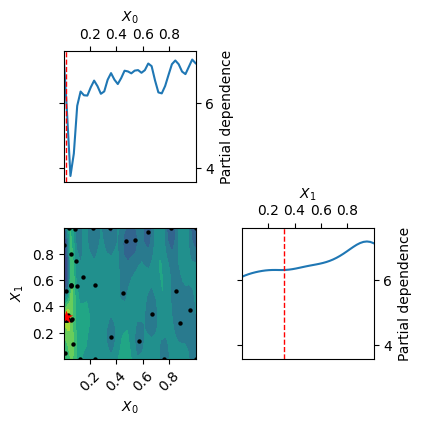

In [13]:
plot_objective(res)

In [ ]:
# %%time
# res = gbrt_minimize(g, [(0.0, 0.3), (0, 0.3)], n_calls = 300)
# res.fun, res.x

## Test solution

In [1]:
carib = Caribou(config=config)

null_action = - np.ones(2, dtype=np.float32)
high_action = 0.5 * np.ones(2, dtype=np.float32)
all_wolves = np.float32([0.0, 0.5])
all_moose = np.float32([0.5, 0.0])
# an_effort = np.float32(res.x)
an_effort = np.float32([0.018989021076692904, 0.3169121824404405])

an_action = 2 * an_effort - 1

Ms, Bs, Ws, ts, rews = [], [], [], [], []
obs, _ = carib.reset()
ep_rew=0
#
pop = carib.population_units()
Ms.append(pop[0])
Bs.append(pop[1])
Ws.append(pop[2])
ts.append(0)
rews.append(ep_rew)
#
for t in range(carib.Tmax):
    ts.append(t+1)
    obs, rew, term, trunc, info = carib.step(an_action)
    pop = carib.population_units()
    Ms.append(pop[0])
    Bs.append(pop[1])
    Ws.append(pop[2])
    ep_rew += rew
    rews.append(ep_rew)
    if term or trunc:
        break
    

ep = pd.DataFrame({
    't': ts,
    'm': Ms,
    'b': Bs,
    'w': Ws,
})

ep.plot(x='t', title=f'{ep_rew}')

NameError: name 'Caribou' is not defined